In [1]:
# Importing all needed libraries
import os

import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd # Data manipulation lib

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, mean_squared_error

import xgboost as xgb
from xgboost import XGBClassifier

## Data loading and preprocessing

The first step of the work is to load and preprocess the data. To begin with, we load the csv file on a pandas dataframe and we specify the first column (the one that contains the datetimes) as the index column.

In [48]:
# Reading csv data file
data = pd.read_csv('Timeseries-data.csv', index_col=0)
print(data.head())

                          P      Rho     T
DateTime                                  
01.01.2009 00:10:00  996.52  1307.75 -8.02
01.01.2009 00:20:00  996.57  1309.80 -8.41
01.01.2009 00:30:00  996.53  1310.24 -8.51
01.01.2009 00:40:00  996.51  1309.19 -8.31
01.01.2009 00:50:00  996.51  1309.00 -8.27


We only want to use the data from the 01/01/2009 to the 31/07/2009. Then, we use MinMaxScaler from Scikit to scale the necessary values between 0 and 1 to ease the differents networks training.

                            P       Rho         T
DateTime                                         
01.01.2009 00:10:00  0.849665  0.698889  0.294557
01.01.2009 00:20:00  0.850483  0.707051  0.286893
01.01.2009 00:30:00  0.849828  0.708803  0.284928
01.01.2009 00:40:00  0.849501  0.704622  0.288858
01.01.2009 00:50:00  0.849501  0.703866  0.289644


<AxesSubplot:xlabel='DateTime'>

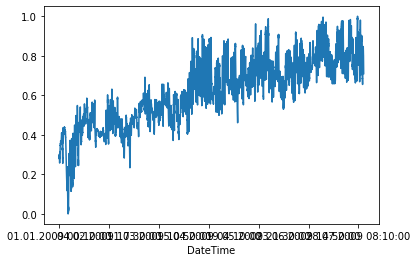

In [49]:
# Selecting data between the 01/01/2009 and the 31/07/2009
data = data.loc['01.01.2009 00:10:00':'31.07.2009 23:50:00']

# Defining scalers
scaler = MinMaxScaler()
# Fit the scalers on the train_data
scaler.fit(data)
# Transform the data
data[['P', 'Rho', 'T']] = scaler.transform(data[['P', 'Rho', 'T']])

print(data.head())

plt.figure()
data['T'].plot()

Finally, we split the data in train and test sets.

In [51]:
# Take 80% of data for training and the remaining 20% for validation
train_size = int(data.shape[0] * 0.8)
train_set, test_set = data[:train_size], data[train_size:]

print("Training values sample:\n")
print(train_set.head())
print("Testing values sample:\n")
print(test_set.head())

Training values sample:

                            P       Rho         T
DateTime                                         
01.01.2009 00:10:00  0.849665  0.698889  0.294557
01.01.2009 00:20:00  0.850483  0.707051  0.286893
01.01.2009 00:30:00  0.849828  0.708803  0.284928
01.01.2009 00:40:00  0.849501  0.704622  0.288858
01.01.2009 00:50:00  0.849501  0.703866  0.289644
Testing values sample:

                            P       Rho         T
DateTime                                         
19.06.2009 14:20:00  0.732864  0.178325  0.814895
19.06.2009 14:30:00  0.731883  0.177768  0.815288
19.06.2009 14:40:00  0.732046  0.177051  0.816074
19.06.2009 14:50:00  0.731719  0.176773  0.817253
19.06.2009 15:00:00  0.732374  0.175021  0.820200


Last little thing before diving through the models definition, we need to define a little method that'll extract the labels from the TimeSeries so we'll be able to asses the models accuracy.

In [52]:
def get_y_from_timeserie(timeserie):
    """ Method that given a timeserie, extract the prediction objective"""
    y = None
    for i in range(len(timeserie)):
        batch_y = timeserie[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

## Univariate  Single Step Forecasting model

In this part, we'll work on the forecasting of one step in the future considering only the T variable to predict future of T.

In [53]:
#Lookback value for the univariate model
look_back: int = 5

# Transforming training and validation sets into TimeSeries
train_timeserie = TimeseriesGenerator(train_set['T'],train_set['T'],length=look_back,sampling_rate=1,stride=1,batch_size=3)
test_timeserie = TimeseriesGenerator(test_set['T'],test_set['T'],length=look_back,sampling_rate=1,stride=1,batch_size=1)

# Printing number of samples
print('Number of train samples: %d' % len(train_timeserie))
print('Number of test samples: %d' % len(test_timeserie))

Number of train samples: 8139
Number of test samples: 6101


Now, we'll define our model and compile it. We choose to use the mse loss function and the adam optimizer.

In [41]:
univariate = Sequential()

univariate.add(LSTM(20, activation='relu', input_shape=(5, 1)))
univariate.add(Dense(1))

univariate.compile(loss='mse', optimizer='adam')

In [42]:
history = univariate.fit(train_timeserie, epochs=20)

Epoch 1/20
8139/8139 [==============================] - 32s 4ms/step - loss: 0.0024
Epoch 2/20
8139/8139 [==============================] - 31s 4ms/step - loss: 1.2270e-04
Epoch 3/20
8139/8139 [==============================] - 36s 4ms/step - loss: 7.3978e-05
Epoch 4/20
8139/8139 [==============================] - 32s 4ms/step - loss: 5.1376e-05
Epoch 5/20
8139/8139 [==============================] - 25s 3ms/step - loss: 3.9767e-05
Epoch 6/20
8139/8139 [==============================] - 30s 4ms/step - loss: 3.2378e-05
Epoch 7/20
8139/8139 [==============================] - 25s 3ms/step - loss: 3.0592e-05
Epoch 8/20
8139/8139 [==============================] - 26s 3ms/step - loss: 3.0515e-05
Epoch 9/20
8139/8139 [==============================] - 31s 4ms/step - loss: 2.8704e-05
Epoch 10/20
8139/8139 [==============================] - 29s 4ms/step - loss: 2.8027e-05
Epoch 11/20
8139/8139 [==============================] - 30s 4ms/step - loss: 2.7082e-05
Epoch 12/20
8139/8139 [===========

In [43]:
# Print loss curve
plt.plot(history.epoch, history.history['loss'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [66]:
# Getting a prediction on the train and validation set
y_pred_train = univariate.predict(train_timeserie)
y_pred_test = univariate.predict(test_timeserie)

# Extract the labels from the TimeSeries
y_train = get_y_from_timeserie(train_timeserie)
y_test = get_y_from_timeserie(test_timeserie)

# Compute root mean squared error to assess the accuracy of the model
train_score = math.sqrt(mean_squared_error(y_train[:,0], y_pred_train[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test[:, 0], y_pred_test[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

(24416, 1)
(6101, 1)
Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


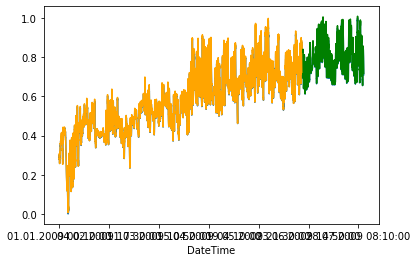

In [67]:
# Shift test predictions for plotting
train_plot = np.empty((data['T'].shape[0], 1))
train_plot[:len(y_pred_train)] = y_pred_train
train_plot[len(y_pred_train):] = np.nan

test_plot = np.empty((data['T'].shape[0], 1))
test_plot[:len(y_pred_train)+(2*look_back)] = np.nan
test_plot[len(y_pred_train)+(2*look_back):] = y_pred_test

# Plot baseline and predictions
plt.figure()
data['T'].plot()
plt.plot(train_plot,color='orange')
plt.plot(test_plot,color='green')
plt.show()

## Multivariate Single Step Forecasting model

In this part, we'll work on the forecasting of one step in the future considering P and Rho variables to predict future of T.

In [108]:
#Lookback value for the univariate model
look_back: int = 3

# Transforming training and validation sets into TimeSeries
train_timeserie = TimeseriesGenerator(
    np.hstack((np.array(train_set['P']).reshape(-1, 1),np.array(train_set['Rho']).reshape(-1, 1))),
    train_set['T'],
    length=look_back,
    sampling_rate=1,
    stride=1,
    batch_size=3
)
test_timeserie = TimeseriesGenerator(
    np.hstack((np.array(test_set['P']).reshape(-1, 1),np.array(test_set['Rho']).reshape(-1, 1))),
    test_set['T'],
    length=look_back,
    sampling_rate=1,
    stride=1,
    batch_size=1
)

# Printing number of samples
print('Number of train samples: %d' % len(train_timeserie))
print('Number of test samples: %d' % len(test_timeserie))

Number of train samples: 8140
Number of test samples: 6103


In [111]:
multivariate = Sequential()

multivariate.add(LSTM(20, activation='relu', input_shape=(look_back, 2)))
multivariate.add(Dense(1))

multivariate.compile(loss='mse', optimizer='adam')

In [112]:
history = multivariate.fit(train_timeserie, epochs=20)

Epoch 1/20
8140/8140 [==============================] - 16s 2ms/step - loss: 0.0035
Epoch 2/20
8140/8140 [==============================] - 16s 2ms/step - loss: 1.3997e-04
Epoch 3/20
8140/8140 [==============================] - 18s 2ms/step - loss: 1.2139e-04
Epoch 4/20
8140/8140 [==============================] - 21s 3ms/step - loss: 1.0516e-04
Epoch 5/20
8140/8140 [==============================] - 14s 2ms/step - loss: 9.7082e-05
Epoch 6/20
8140/8140 [==============================] - 15s 2ms/step - loss: 8.6999e-05
Epoch 7/20
8140/8140 [==============================] - 15s 2ms/step - loss: 7.9382e-05
Epoch 8/20
8140/8140 [==============================] - 14s 2ms/step - loss: 7.0748e-05
Epoch 9/20
8140/8140 [==============================] - 15s 2ms/step - loss: 6.5539e-05
Epoch 10/20
8140/8140 [==============================] - 15s 2ms/step - loss: 5.8280e-05
Epoch 11/20
8140/8140 [==============================] - 15s 2ms/step - loss: 5.1053e-05
Epoch 12/20
8140/8140 [===========

In [113]:
# Print loss curve
plt.plot(history.epoch, history.history['loss'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [114]:
# Getting a prediction on the train and validation set
y_pred_train = multivariate.predict(train_timeserie)
y_pred_test = multivariate.predict(test_timeserie)

# Extract the labels from the TimeSeries
y_train = get_y_from_timeserie(train_timeserie)
y_test = get_y_from_timeserie(test_timeserie)

# Compute root mean squared error to assess the accuracy of the model
train_score = math.sqrt(mean_squared_error(y_train[:,0], y_pred_train[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(y_test[:, 0], y_pred_test[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

(24418, 1)
(6103, 1)
Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


In [118]:
# Shift test predictions for plotting
train_plot = np.empty((data['T'].shape[0], 1))
train_plot[:len(y_pred_train)] = y_pred_train
train_plot[len(y_pred_train):] = np.nan

test_plot = np.empty((data['T'].shape[0], 1))
test_plot[:len(y_pred_train)+(2*look_back)] = np.nan
test_plot[len(y_pred_train)+(2*look_back):] = y_pred_test

# Plot baseline and predictions
plt.figure()
data['T'].plot()
plt.plot(train_plot,color='orange')
plt.plot(test_plot,color='green')
plt.show()